<!-- # Unsupervised State-Inference
In reinforcement learning, it's often useful to assume that we can describe a problem in a discrete and finite set of states. For example, we might have an known number of independent bandits, or a grid-world with defined locations of objects. One reason this representation is useful is that it can dramtically simplify the problem of planning: given a known set of states $S$, a transition function $T(s,a,s') = p(s'|s,a)$ that defines the conditional probability of arriving in state $s'$ having taken action $a$ in state $s'$, and reward function $R(s, a, s')$ that defines the values over our state-action space, there are known polynomial time planning algorithms. 

In naturalistic enviornments, however, it can be difficult to translate raw perceptual stimuli into discrete states. Typically, states are an assumption of an enviornment and we often lack a principaled way to discover them from observation alone.  

Here, the goal is to discover states using an unsupervised learning algorithm.  We'll assume states are discrete, independent latent variables and use variational inference to learn conditional probability distribution over states. More formally, given a real-valued observation vector $x\in R^d$, we want to learn a paramterized function $f_\theta(x)$ that defines a probability distribution over states $s$. We'll assume that we don't have access to the states, but only have the observation tuples $(x, x')$ that define transitions an agent makes in an enviornment. We will use a discrete variaitional autoencoder (VAE) for our unsupervised algorithm.

 -->


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("..")

# import warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.metrics import pairwise_distances

from src.model.agents.utils.tabular_agents import (
    TabularRewardEstimator,
    TabularTransitionEstimator,
    value_iteration,
    # StateReconstruction,
)
from src.model.state_inference.vae import DEVICE, StateVae
from src.task.gridworld import OpenEnv
from src.task.transition_model import TransitionModel
from src.utils.sampling_functions import sample_random_walk_states, sample_states
from src.utils.config_utils import parse_task_config, parse_model_config
from src.utils.data import ObservationDataset
from src.utils.pytorch_utils import (
    convert_float_to_8bit,
    make_tensor,
    convert_8bit_array_to_float_tensor,
    convert_8bit_to_float,
)
from src.utils.utils import BayesianFilter
from src.task.thread_the_needle import make_thread_the_needle_walls

In [3]:
import sys

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")

python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
torch 2.6.0.dev20241126
device = mps


## Toy World
First, it's useful to construct a toy world and the stimuli we'll need for the model. I'm making the assumption that the underlying MDP is a $n\times n$ grid-world that's embedded in much higher dimensional observational space. To do so, I'll construct a much larger grid with dimensions $m\times m$, where $m > n$, and evenly space the states in the grid. I then add a couple of sources of noise and convole the observations with a Gaussian kernel to generate the observations.  This increases the dimensionality substantially (going from $n^2$ to $m^2$) and adds significant overlap between the observations.

We can think of these observations as a toy model for soemthing like a robot's estimate of it's position, or a perhaps as a model of hippocampal grid cells.  Importantly, this doesn't have to be exclusively a spatial model -- none of the subsequent modeling uses visual inductive biases and I'm hopeful this is more general toy model.

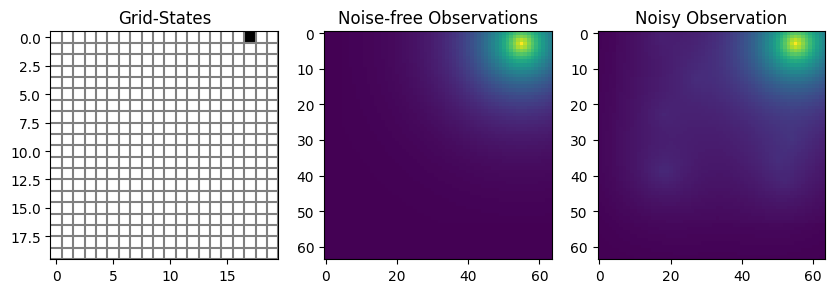

In [4]:
TASK_CONFIG_FILE = "../configs/env_config.yml"
TASK_NAME = "thread_the_needle"
TASK_CLASS = OpenEnv

MODEL_NAME = "cnn_vae"
MODEL_CONFIG_FILE = "../configs/vae_config.yml"

env_kwargs = parse_task_config(TASK_NAME, TASK_CONFIG_FILE)
model_config = parse_model_config(MODEL_NAME, MODEL_CONFIG_FILE)

task = TASK_CLASS.create_env(**env_kwargs)
observation_model = task.observation_model

# Discritized states: a 20x20 grid of states, which we embed by spacing
# evenly in a nXn space

# show an example location
s = 17
observation_model.display_state(s)

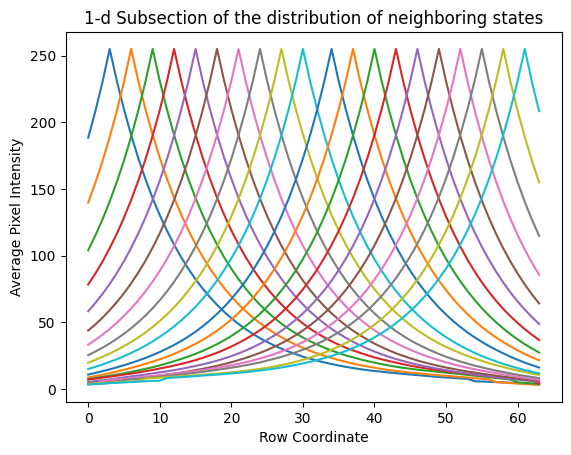

In [5]:
## show the 1-d overlap of neighboring states
x, _ = observation_model.get_obs_coords(26)

for s in range(20, 40):
    obs = torch.mean(
        torch.stack(
            [
                make_tensor(observation_model.embed_state_corrupted(s))[x, :]
                for _ in range(100)
            ]
        ),
        axis=0,
    )
    plt.plot(obs)

plt.xlabel("Row Coordinate")
plt.ylabel("Average Pixel Intensity")
plt.title("1-d Subsection of the distribution of neighboring states")
plt.show()

Notably, there is a overlap in our observation space. We can control this overlap parametrically by changing the length scale of our convolution kernel (this is akin to a wider belief distribution)

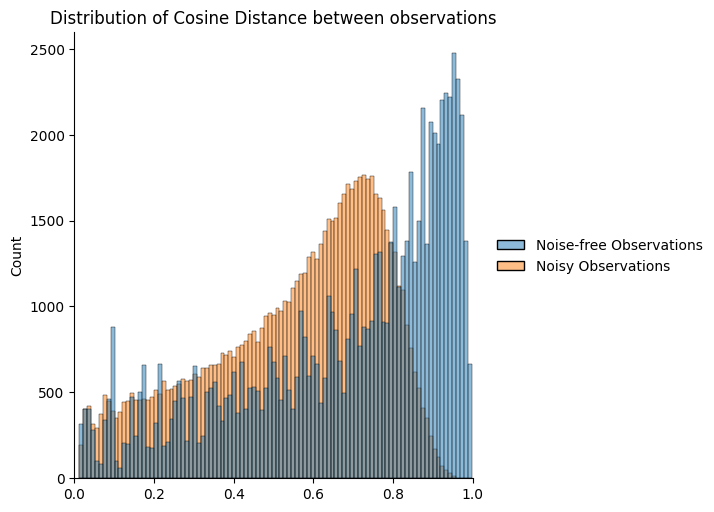

In [6]:
def embed_dist(observation_model, corrupt=False):
    def embed(s):
        if corrupt:
            return observation_model.embed_state_corrupted(s).reshape(-1)
        return observation_model.embed_state(s).reshape(-1)

    sample_embeddings = {s: embed(s) for s in observation_model.states.keys()}

    distances = pairwise_distances(
        np.array(list(sample_embeddings.values())), metric="cosine"
    )

    mask = np.tril(np.ones_like(distances, dtype=bool), k=-1)
    return distances.reshape(-1)[mask.reshape(-1)]


sns.displot(
    {
        "Noise-free Observations": embed_dist(observation_model, corrupt=False),
        "Noisy Observations": embed_dist(observation_model, corrupt=True),
    },
    bins=100,
)

plt.title("Distribution of Cosine Distance between observations")
plt.xlim([0, 1])
plt.show()

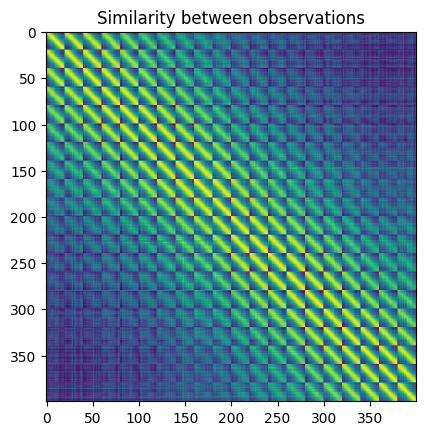

In [7]:
def sample_embedding_distances():
    sample_embeddings = {}
    for s in observation_model.states.keys():
        sample_embeddings[s] = observation_model(s).reshape(-1)

    embedding_distances = 1 - pairwise_distances(
        np.array(list(sample_embeddings.values())), metric="cosine"
    )
    return embedding_distances


embedding_distances = sample_embedding_distances()
plt.title("Similarity between observations")
plt.imshow(embedding_distances)

In [8]:
mask = np.triu(np.ones((400, 400)), k=1).reshape(-1)
np.mean(embedding_distances.reshape(-1)[mask == 1])

0.4576515662858208

In [9]:
def sample_embedding_distances():
    sample_embeddings = {}
    for s in observation_model.states.keys():
        sample_embeddings[s] = observation_model(s).reshape(-1)

    sample_embeddings_2 = {}
    for s in observation_model.states.keys():
        sample_embeddings_2[s] = observation_model(s).reshape(-1)
    # print(sample_embeddings)

    embedding_distances = 1 - pairwise_distances(
        np.array(list(sample_embeddings_2.values())),
        np.array(list(sample_embeddings.values())),
        metric="cosine",
    )
    return embedding_distances


embedding_distances_self = sample_embedding_distances()
# plt.title("Similarity between observations")
# plt.imshow(embedding_distances)
np.diag(embedding_distances_self).mean()

0.9880752171698208

# State-values
Show ground truth state values for a fixed discount factor

Text(0.5, 1.0, 'Value function for gamma = 0.95')

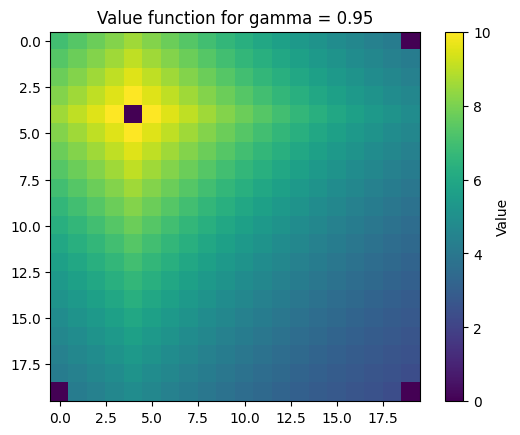

In [10]:
gamma = 0.95    
q, v = task.get_state_values(gamma=gamma)
plt.imshow(v[:-1].reshape(20, 20))
plt.colorbar(label="Value")
plt.title(f"Value function for gamma = {gamma}")

## Discrete State-VAE
The core idea is to use a discrete Variational Autoencoder, where states are represented as one-hot vector embeddings. The VAE is an encoder/decoder model, where the encoder learns a parameterized probability distribution over embeddings and the decoder reconstructs the original input vector from the vector embedding. 

The model has three key components:
* An encoder model: $f_\theta(x) = \omega$
* A Gumbel-Sofmax probability distribution over states $p_\omega(z) \propto exp(\omega + \epsilon)$, where $ \epsilon$ is an external source of noise drawn from the Gumbel distribution.
* A decoder model: $d_\theta(z) = x$

The model is trained with stochastic variational gradient descent: an input is passed through the decoder, a state is sampled from the Gumbel-softmax distribution, and the input is reconstructed by the decoder. This forward pass is used to calculate the ELBO loss function:
$$ELBO(x) = \log q(x|z) - KL(q(z|x)||p(z))$$
where $\log q(x|z)$ is the reconstruction loss of the network and $KL(q(z|x)||p(z))$ is the KL diveregence of the learned embedding distribution and a prior over states. Under gentle assumptions, $-\log q(x|z)$ is the mean squared error of the reconstructed output relative to the input and the $KL(q(z|x)||p(z))$ becomes the entropy of the embedding distribution.




### Generate Dataset
Sample states from a Random walk on the grid-world and then generate noisy observations

In [11]:
## Simulation Parameters
N_TRAINING_EXAMPLES = 30000
BATCH_SIZE = 64

transition_model = TransitionModel(task.observation_model.h, task.observation_model.w)

# Create the dataloaders from the dataset
args = [transition_model, observation_model]
train_obs = ObservationDataset(*args, N_TRAINING_EXAMPLES)
test_obs = ObservationDataset(*args, train=False)

train_loader = data.DataLoader(
    train_obs,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = data.DataLoader(test_obs, batch_size=len(test_obs))

### Train the Model

In [12]:
# ### Model + Training Parameters
model_config = parse_model_config(MODEL_NAME, MODEL_CONFIG_FILE)

vae_model = StateVae.make_from_configs(model_config, env_kwargs).to(DEVICE)
print(vae_model)
total_params = sum(p.numel() for p in vae_model.parameters())
print(f"Number of parameters: {total_params}")
# agent.learn(1000, estimate_batch=False, progress_bar=False)

StateVae(
  (encoder): CnnEncoder(
    (cnn): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
        (act): ELU(alpha=1.0)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (act): ELU(alpha=1.0)
      )
      (2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): ELU(alpha=1.0)
      )
    )
    (mlp): Sequential(
      (0): Linear(in_features=3136, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (decoder): CnnDecoder(
    (fc): Linear(in_features=64, out_features=2048, bias=True)
    (deconv): Sequential(
      (0): ConvTransposeBlock(
        (conv_t): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (act): ELU(alpha=1.0)
      )
      (1): ConvTransposeBlock(
        (conv_t): ConvTranspose2d(256, 128, kernel_size=

In [13]:
from collections import Counter

model_config = parse_model_config(MODEL_NAME, MODEL_CONFIG_FILE)

# check the untrained loss
vae_model = StateVae.make_from_configs(model_config, env_kwargs).to(DEVICE)
vae_model.diagnose_loss(next(iter(train_loader)))

n_states = []
for ii in range(10):
    vae_model = StateVae.make_from_configs(model_config, env_kwargs).to(DEVICE)

    with torch.no_grad():
        (logits, z), x_hat = vae_model(next(iter(test_loader)).to(DEVICE).float())

        # convert to integers
        z = torch.argmax(z, 2).detach().cpu().numpy()

        # make into a state tuple
        states = [tuple(z0) for z0 in z]
    n_states.append(len(Counter(states)))

print(f"Number of Unique states in test set {np.mean(n_states)}")

Total Loss: 500.2326, Reconstruction: 500.2344, KL-Loss: 0.0018, beta: 1.0
Number of Unique states in test set 400.0


In [14]:
# Train the the model
N_EPOCHS = 20
LR = 1e-3

model_config = parse_model_config(MODEL_NAME, MODEL_CONFIG_FILE)
vae_model = StateVae.make_from_configs(model_config, env_kwargs).to(DEVICE)

optim = torch.optim.AdamW(vae_model.parameters(), lr=LR)

vae_model.fit(N_EPOCHS, train_loader, optim=optim, test_dataloader=test_loader, verbose=True, grad_clip=1.0)

Epoch 0, ELBO Loss (test) 25.724953
Epoch 1, ELBO Loss (test) 26.680264
Epoch 2, ELBO Loss (test) 21.688948
Epoch 3, ELBO Loss (test) 19.195547
Epoch 4, ELBO Loss (test) 17.358929
Epoch 5, ELBO Loss (test) 17.565413
Epoch 6, ELBO Loss (test) 17.073986
Epoch 7, ELBO Loss (test) 16.054651
Epoch 8, ELBO Loss (test) 15.920757
Epoch 9, ELBO Loss (test) 16.297810
Epoch 10, ELBO Loss (test) 15.558270
Epoch 11, ELBO Loss (test) 14.800523
Epoch 12, ELBO Loss (test) 14.274183
Epoch 13, ELBO Loss (test) 14.300129
Epoch 14, ELBO Loss (test) 14.485193
Epoch 15, ELBO Loss (test) 13.984076
Epoch 16, ELBO Loss (test) 14.062035
Epoch 17, ELBO Loss (test) 13.920422
Epoch 18, ELBO Loss (test) 13.420969
Epoch 19, ELBO Loss (test) 13.937780


([736.6372680664062,
  614.503662109375,
  537.369140625,
  456.85821533203125,
  391.0180969238281,
  335.9859619140625,
  292.9825134277344,
  256.4927978515625,
  224.08938598632812,
  191.9354248046875,
  173.6304473876953,
  153.9164276123047,
  134.34762573242188,
  119.68623352050781,
  105.03916931152344,
  92.96778869628906,
  82.61945343017578,
  71.70948028564453,
  66.22398376464844,
  55.76957321166992,
  51.48613739013672,
  49.73004150390625,
  44.792808532714844,
  46.69922637939453,
  43.467994689941406,
  44.29588317871094,
  39.990421295166016,
  46.337242126464844,
  41.16058349609375,
  41.638092041015625,
  42.77444076538086,
  39.55493927001953,
  39.55244827270508,
  38.345054626464844,
  40.512962341308594,
  35.84440994262695,
  36.309898376464844,
  39.115997314453125,
  38.498268127441406,
  37.97420120239258,
  38.582984924316406,
  39.773536682128906,
  40.69535827636719,
  39.26751708984375,
  40.46875762939453,
  37.75299072265625,
  33.68710708618164,
 

In [15]:
vae_model.diagnose_loss(next(iter(train_loader)))

Total Loss: -2.6983, Reconstruction: 4.5624, KL-Loss: 7.2606, beta: 1.0


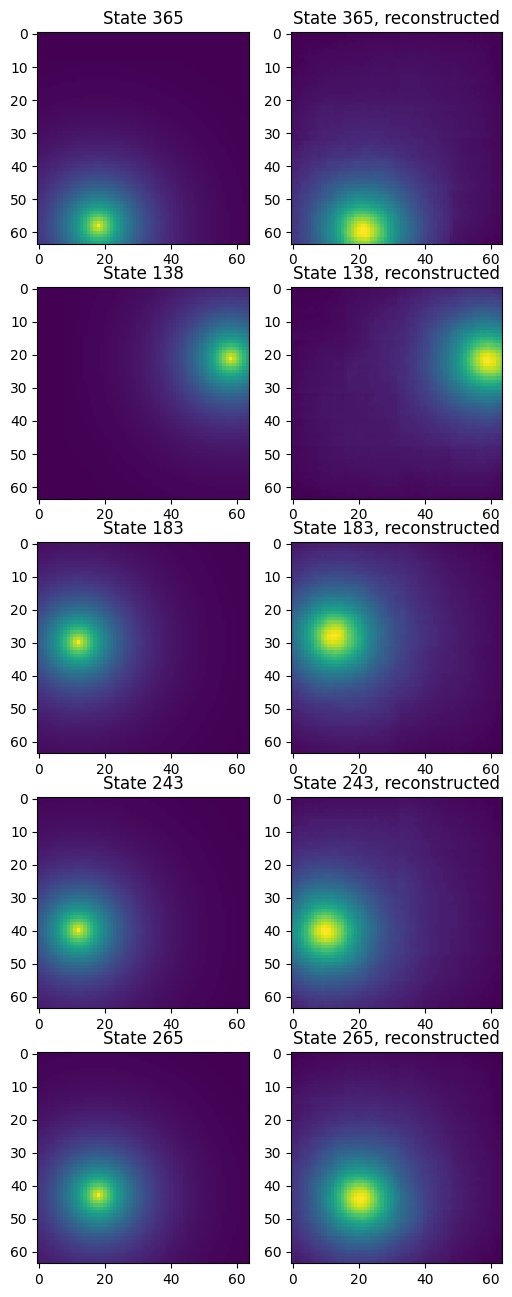

In [16]:
vae_model.eval()
s = np.random.randint(0, vae_model.z_dim * vae_model.z_layers)
ii = 0
fig, axes = plt.subplots(5, 2, figsize=(6, 16))
for s in range(5):
    s = np.random.randint(400)
    _, X_hat = vae_model(test_obs[s, :].to(DEVICE))

    axes[ii][0].imshow(convert_float_to_8bit(test_obs[s, :].squeeze()))
    axes[ii][1].imshow(convert_float_to_8bit(X_hat.squeeze().detach().cpu()).numpy())
    axes[ii][0].set_title(f"State {s}")
    axes[ii][1].set_title(f"State {s}, reconstructed")

    ii += 1

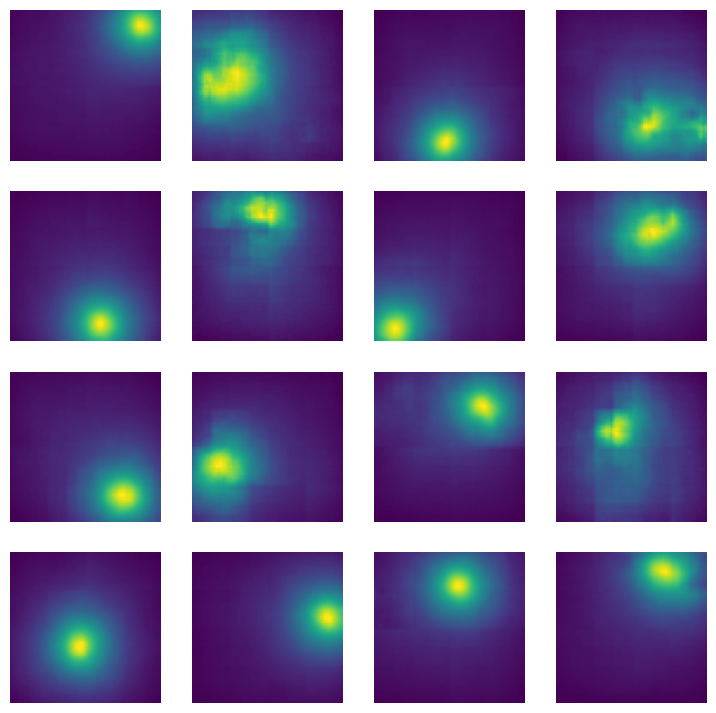

In [17]:
import torch.nn.functional as F

# Sample generatively

z_layers = model_config["vae_kwargs"]["z_layers"]
z_dim = model_config["vae_kwargs"]["z_dim"]

N = 4


def sample_random_state():
    z = torch.randint(high=z_dim, size=tuple([z_layers]))
    return F.one_hot(z, num_classes=z_dim).to(DEVICE)


fig, axes = plt.subplots(N, N, figsize=(9, 9))

vae_model.eval()
for t in range(N**2):
    with torch.no_grad():
        z = sample_random_state()
    X_hat = vae_model.decode(z).detach().cpu()

    r, c = t // N, t % N
    plt.sca(axes[r][c])
    plt.imshow(convert_float_to_8bit(X_hat.squeeze()))
    plt.axis("off")

plt.show()

### Evaluate the consistency of the inferred states

In [18]:
n_batch = 25
n_states = transition_model.n_states

obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(n_states)
            for _ in range(n_batch)
        ]
    )
)[:, None, ...].to(DEVICE)

z = vae_model.get_state(obs)

hash_vector = np.array([vae_model.z_dim**ii for ii in range(vae_model.z_layers)])

z = z.dot(hash_vector)
# d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
# d = d.astype(np.float32)

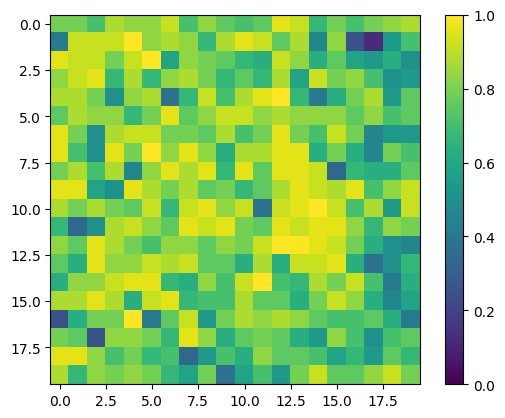

In [19]:
unique_counts = np.array([np.unique(row).size for row in z.reshape(n_states, n_batch)])
# convert to a distance metric
d = 1 - (unique_counts.reshape(20, 20) - 1) / (25 - 1)

plt.imshow(d, vmin=0, vmax=1)
plt.colorbar()

In [20]:
unique_counts

array([ 6,  6,  8,  4,  5,  5,  3,  8,  5,  7,  8,  7,  2,  3,  9,  6,  8,
        6,  5,  4, 15,  3,  3,  3,  1,  5,  4,  5,  9,  4,  2,  3,  7,  4,
       14,  5, 19, 22, 12,  8,  2,  3,  3,  6,  3,  1, 11,  5,  6,  7,  9,
       10,  3,  5, 10,  7, 11, 12, 10, 13,  5,  3,  2,  9,  4,  9,  5,  4,
        6,  9,  7,  9,  4, 11,  3,  6,  5,  8, 13, 12,  4,  4,  6, 13,  5,
        4, 16,  9,  3,  8,  4,  2,  1,  9, 15, 10,  6,  4, 12,  7,  7,  4,
        5,  5,  9,  6,  2,  7,  5,  3,  3,  5,  4,  5,  5,  5,  7,  5,  8,
        7,  2,  6, 13,  4,  3,  3,  6,  6,  7,  4,  8,  6,  2,  6,  8,  3,
        6, 14, 12, 12,  2,  8, 13,  2,  6,  1,  5,  2,  5, 10,  4,  4,  2,
        2, 10,  6, 10, 14,  6,  8,  6,  4,  8,  4, 14,  5,  2,  4,  2,  9,
        2,  7,  2,  2,  3, 17,  9, 10, 10,  7,  2,  2, 11, 13,  2,  4,  6,
        4,  7,  6,  9,  7,  4,  2,  3,  4,  2,  8,  5,  3,  4,  6,  4,  6,
        7,  3,  9,  3,  2,  5,  3, 16,  3,  2,  1,  3,  8,  4, 12,  3,  9,
       17, 13,  4,  3,  5

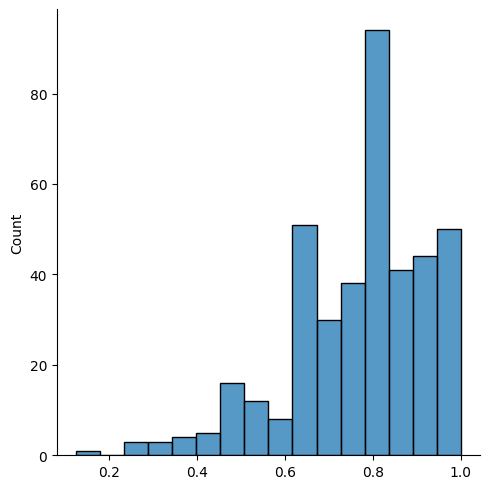

In [21]:
sns.displot(d.reshape(-1))

In [22]:
# # calculate how similar each state's representation is to itself
# mask = np.tril(np.ones((n_batch, n_batch)), k =-1)
# ii = 25

# self_sim = [
#     np.sum(d[n_batch*ii:n_batch*(ii+1),n_batch*ii:n_batch*(ii+1)] * mask)  / mask.sum()
#     for ii in range(n_states)
# ]
# plt.imshow(np.reshape(self_sim, (20, 20)))
# task.display_gridworld(plt.gca(), wall_color="w")

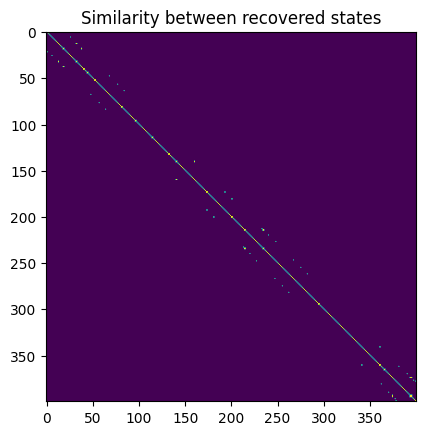

In [23]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = vae_model.get_state(obs)

hash_vector = np.array([vae_model.z_dim**ii for ii in range(vae_model.z_layers)])

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.title("Similarity between recovered states")
plt.imshow(d)

<Axes: title={'center': 'Thread-the-needle states'}>

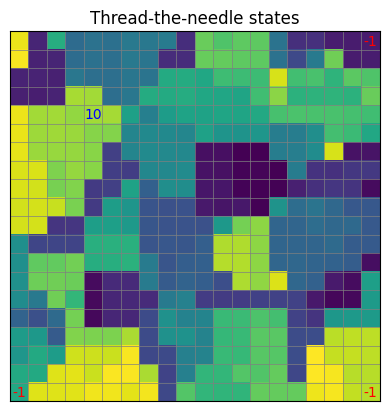

In [24]:
# plot the overlap of different states
# number the states and plot them
clusters = {}
k = 0
for z0 in sorted(z):
    if z0 not in clusters.keys():
        clusters[z0] = k
        k += 1
clustered_states = np.array([clusters[z0] for z0 in z])
plt.imshow(clustered_states.reshape(-1, 20))
task.display_gridworld(plt.gca(), wall_color="w")

In [26]:
obs_a = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)

obs_b = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)

z_a = vae_model.get_state(obs_a)
z_b = vae_model.get_state(obs_a)

d_emb = pairwise_distances(
    obs_a.view(400, -1).cpu().detach().numpy(),
    obs_b.view(400, -1).cpu().detach().numpy(),
)

d_latent = pairwise_distances(
    z_a, z_b, metric=lambda x, y: np.sum(x0 != y0 for x0, y0 in zip(x, y))
)

/var/folders/fm/4kcsh05n3y34x3qkmmlmn6900000gn/T/ipykernel_88521/1778271523.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  z_a, z_b, metric=lambda x, y: np.sum(x0 != y0 for x0, y0 in zip(x, y))


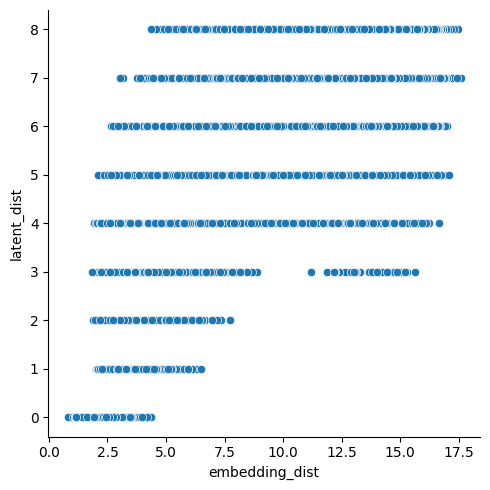

In [27]:
import pandas as pd

# plt.scatter(d_emb.reshape(-1), d_latent.reshape(-1))
sns.relplot(
    data=pd.DataFrame(
        {"latent_dist": d_latent.reshape(-1), "embedding_dist": d_emb.reshape(-1)}
    ),
    x="embedding_dist",
    y="latent_dist",
)

In [28]:
# pd.DataFrame(
#     {
#         "latent_dist": d_latent.reshape(-1),
#         "embedding_dist": d_emb.reshape(-1),
#         "same_state": np.eye(400 * 400).reshape(-1) == 1,
#     },
# )

In [29]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)
euc

array([[ 0.,  1.,  2., ..., 36., 37., 38.],
       [ 1.,  0.,  1., ..., 35., 36., 37.],
       [ 2.,  1.,  0., ..., 34., 35., 36.],
       ...,
       [36., 35., 34., ...,  0.,  1.,  2.],
       [37., 36., 35., ...,  1.,  0.,  1.],
       [38., 37., 36., ...,  2.,  1.,  0.]])

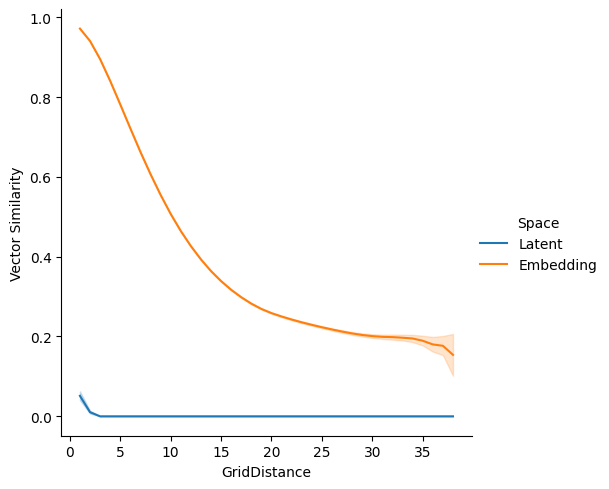

In [30]:
import pandas as pd

_df = pd.concat(
    [
        pd.DataFrame(
            {
                "Space": ["Latent"] * 160000,
                "Vector Similarity": d.reshape(-1) == 1,
                "GridDistance": euc.reshape(-1),
            }
        ),
        pd.DataFrame(
            {
                "Space": ["Embedding"] * 160000,
                "Vector Similarity": embedding_distances.reshape(-1),
                "GridDistance": euc.reshape(-1),
            }
        ),
    ]
)


sns.relplot(
    _df[_df.GridDistance > 0],
    x="GridDistance",
    y="Vector Similarity",
    hue="Space",
    kind="line",
)

/var/folders/fm/4kcsh05n3y34x3qkmmlmn6900000gn/T/ipykernel_88521/119644881.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  d = pairwise_distances(z, metric=lambda x, y: np.sum(x0 == y0 for x0, y0 in zip(x, y)))


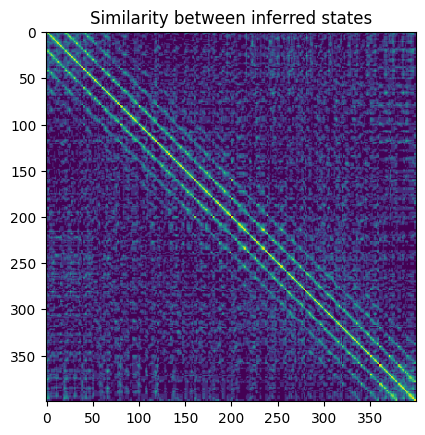

In [31]:
# noise free
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = vae_model.get_state(obs)
z
# hash_vector = np.array(
#             [
#                 vae_model.z_dim**ii
#                 for ii in range(vae_model.z_layers)
#             ]
#         )

# z = z.dot(hash_vector)
d = pairwise_distances(z, metric=lambda x, y: np.sum(x0 == y0 for x0, y0 in zip(x, y)))
plt.title("Similarity between inferred states")
plt.imshow(d)

In [32]:
d.mean()

1.1695375

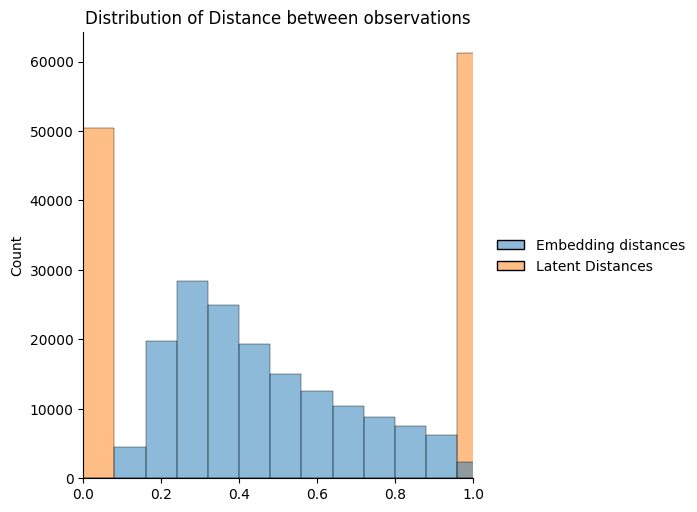

In [33]:
sns.displot(
    {
        "Embedding distances": embedding_distances.reshape(-1),
        "Latent Distances": d.reshape(-1),
    },
    bins=100,
)

plt.title("Distribution of Distance between observations")
plt.xlim([0, 1])
# plt.yscale('log')
plt.show()

# Transition Model
The idea here is to uses Bayesian filtering to smooth the observations model. Formally, if the observation model is 
$p_\omega(z|o)$, we want some model $p_\theta(z'|z)$



### Evaluate State-Inference


In [38]:
task.observation_model.h

20

In [40]:
HEIGHT, WIDTH = task.observation_model.h, task.observation_model.w

n = HEIGHT * WIDTH * 100

# generate a new set of observations for training
y_train = sample_states(transition_model, n)

# Use a trained classifier to determine states from latent representation
# recon_model = StateReconstruction(vae_model, observation_model, y_train)

In [ ]:
# # from state_inference.tabular_models import StateReconstruction

# n = 500
# epsilon = 1e-10  # for numerical stability
# y_test = sample_random_walk_states(transition_model, n, 0)
# y_hat_logprob = np.log(recon_model.predict_prob(y_test) * (1 - epsilon) + epsilon)

# acc_obs_model = recon_model.accuracy(y_hat_logprob, y_test)
# print(f"State Inference Accuracy (observation model)      : {acc_obs_model.mean():.4f}")

# epsilon = 0.0001  # epsilon smoothing helps with numerical stability

# filtered_state_prob = BayesianFilter(
#     y_hat_logprob,
#     np.log(transition_model.random_transitions * (1 - epsilon) + epsilon),
# )
# acc_smooth_model = recon_model.accuracy(filtered_state_prob, y_test)
# print(
#     f"State Inference Accuracy (w/ transition smoothing): {acc_smooth_model.mean():.4f}"
# )

In [ ]:
# idx = 50
# fig, axes = plt.subplots(1, 3)
# axes[0].imshow(np.exp(y_hat_logprob[idx].reshape(20, 20)))
# axes[1].imshow(np.exp(filtered_state_prob[idx].reshape(20, 20)))
# axes[2].imshow(
#     np.exp(filtered_state_prob[idx].reshape(20, 20))
#     - np.exp(y_hat_logprob[idx].reshape(20, 20))
# )
# axes[0].set_title("Observation Model")
# axes[1].set_title("Pomdp Filtering")
# axes[2].set_title("difference")

# Value Iteration
Now that we have a state-inference model, we want to take the model to do a planning task.  The first step is to generate a new random walk, where rewards are observed (ideally a much shorter walk) and use these to estimate a transition and reward function.  We can then use value iteration, and re-projecte the value function into the original space for visualization.  

Ultimately, we'd like to use a task.  We could implment DYNA-Q on the state space, and then recreate figure 8.2 from Sutton and Barto (second edition, page 165 below) 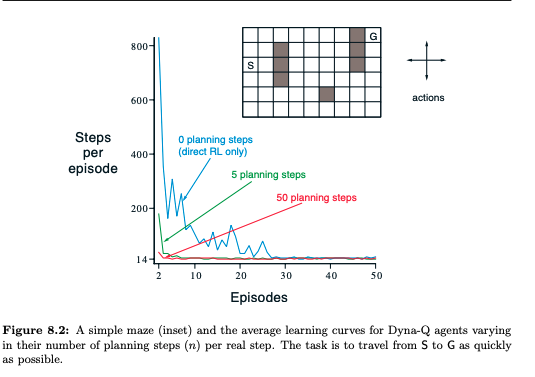

### Transition Function

Text(19, 19, 'S')

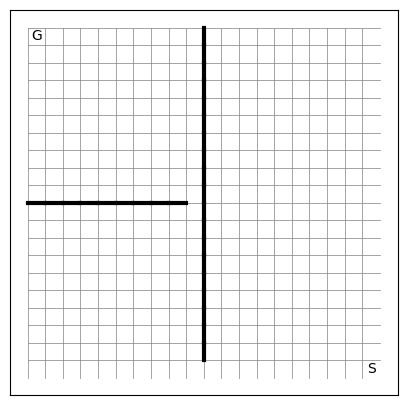

In [41]:
thread_the_needle_task = TransitionModel(
    HEIGHT, WIDTH, make_thread_the_needle_walls(20)
)
ax = thread_the_needle_task.display_gridworld()

ax.annotate("G", (0, 0), ha="center", va="center", c="k")
ax.annotate("S", (19, 19), ha="center", va="center", c="k")

## Reward functions

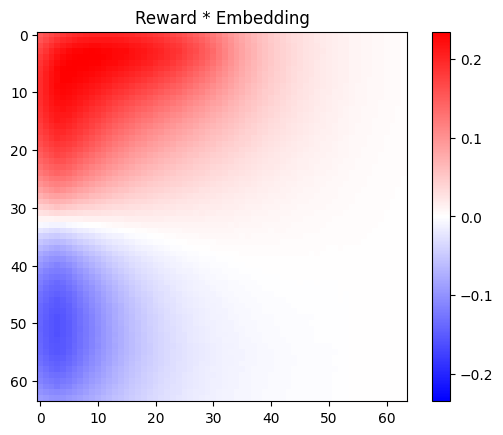

In [42]:
# Thread the needle reward function
rewards = {ii: 1 for ii in range(0, 10)}
rewards.update({20 * ii: 1 for ii in range(0, 10)})
rewards.update({20 * ii: -1 for ii in range(10, 20)})


# for Display purposes, we can show the reward function embedded in the original
# space.  This doesn't have a clean interpretation, but it shows us
# roughly where pixels are associated with positive or negative reward

reward_map = (
    torch.stack(
        [
            convert_8bit_array_to_float_tensor(observation_model.embed_state(s))[
                None, ...
            ]
            * r
            for s, r in rewards.items()
        ]
    )
    .mean(dim=0)
    .reshape(64, -1)
)

_max = max([abs(reward_map.min()), abs(reward_map.max())])
plt.imshow(reward_map, cmap="bwr", vmin=-_max, vmax=_max)
plt.title("Reward * Embedding")
plt.colorbar()
plt.show()

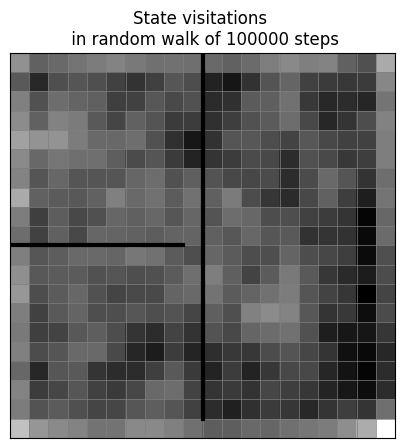

In [43]:
from collections import Counter

n = 100000

walk = sample_random_walk_states(transition_model, n, 0)
state_counts = Counter(walk)
state_counts = np.array([state_counts[ii] for ii in range(transition_model.n_states)])

# state_counts, walk = thread_the_needle_task.generate_random_walk(n, 0)
ax = thread_the_needle_task.display_gridworld()
plt.imshow(1 - state_counts.reshape(HEIGHT, WIDTH), cmap="gray")
plt.title(f"State visitations \n in random walk of {n} steps")
plt.show()

# observation_model()
walk_observations = torch.stack(
    [convert_8bit_array_to_float_tensor(observation_model(s)).view(-1) for s in walk]
)
walk_rewards = [rewards.get(s, 0) for s in walk]

## Value iteration

In [ ]:
walk_states = vae_model.get_state(walk_observations.to(DEVICE))
walk_states = [tuple(s) for s in walk_states]

transition_model_tab = TabularTransitionEstimator()
transition_model_tab.batch_update(walk_states)

reward_model = TabularRewardEstimator()
reward_model.batch_update(walk_states, walk_rewards)

AssertionError: Tensor Shape torch.Size([100001, 4096]) does not match target (1, 64, 64)

In [ ]:
q, v = value_iteration(
    {"N": transition_model_tab}, reward_model, gamma=0.80, iterations=100
)

In [ ]:
v_s = np.zeros((1, HEIGHT * WIDTH))
for z, vz in v.items():
    ps = recon_model.predict_state_prob_from_z([z])
    v_s += ps * vz

# plt.imshow(v_s.reshape(HEIGHT, WIDTH))

ax = thread_the_needle_task.display_gridworld()
plt.imshow(v_s.reshape(HEIGHT, WIDTH), cmap="bwr")
plt.title(f"Reward Value \n in random walk of {n} steps")
plt.colorbar()
plt.show()

In [ ]:
value_function = []
for s, vs in v.items():
    x = vae_model.decode_state(s)
    value_function.append(x * vs)

plt.imshow(
    np.array(value_function).squeeze().mean(axis=0).reshape(MAP_HEIGHT, -1), cmap="bwr"
)

# plt.imshow(reward_map, cmap="bwr")
plt.title("Value Function")
plt.colorbar()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(1 - state_counts.reshape(HEIGHT, WIDTH), cmap="gray")
axes[0].set_title(f"State visitations \n in random walk of {n} steps")
thread_the_needle_task.display_gridworld(ax=axes[0])

mappable = axes[1].imshow(v_s.reshape(HEIGHT, WIDTH), cmap="viridis")
axes[1].set_title(f"Reward Value \n over grid-states")
thread_the_needle_task.display_gridworld(ax=axes[1])
# fig.colorbar(ax=axes[1])

axes[2].imshow(
    np.array(value_function).squeeze().mean(axis=0).reshape(MAP_HEIGHT, -1),
    cmap="viridis",
)
axes[2].set_title("Value Function \n over the observation space")

plt.show()